# Analysis of business indicators

Product - the entertainment application Procrastinate Pro+.

In recent months, the application has been operating at a loss, despite significant advertising budgets.

The goal is to identify the causes and help the company turn a profit.

Tasks:
- Determine where users come from and what devices they use,
- Determine the cost of attracting users from different advertising channels;
- Determine how much money each customer brings in,
- Determine when customer acquisition costs are recovered,
- Identify factors that hinder customer acquisition.

There is data available on users attracted from May 1 to October 27, 2019:
- Server logs with information about their site visits,
- Download of their purchases for this period,
- Advertising expenses.

Data description:
There are three datasets available. The file visits_info_short.csv contains the server log with information about site visits, orders_info_short.csv contains information about orders, and costs_info_short.csv contains information about advertising expenses.

Structure of visits_info_short.csv:
- User Id - a unique user identifier,
- Region - user's country,
- Device - user's device type,
- Channel - identifier of the traffic source,
- Session Start - date and time the session began,
- Session End - date and time the session ended.

Structure of orders_info_short.csv:

- User Id - a unique user identifier,
- Event Dt - date and time of purchase,
- Revenue - purchase amount.

Structure of costs_info_short.csv:

- dt - date of the advertising campaign,
- Channel - identifier of the advertising source,
- Costs - expenses for this campaign.

## Data loading and preprocessing

We load all necessary libraries and data about visits, orders, and advertising expenses from CSV files into variables. We examine the data and perform preprocessing. We check for missing values and duplicates in the data. We also check the data types in all columns.

In [1]:
#загрузим необходимые библиотеки и модули
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загрузим данные в переменные
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

# посмотрим на таблицы
visits.info(), orders.info(), costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

(None, None, None)

We see that the columns have different cases everywhere, so we'll convert them to a consistent case and remove any spaces.

In [3]:
# переименуем столбцы
visits.rename(columns = {'User Id':'user_id', 
                         'Region':'region', 
                         'Device':'device', 
                         'Channel':'channel', 
                         'Session Start':'session_start', 
                         'Session End':'session_end'}, 
              inplace = True )
orders.rename(columns = {'User Id':'user_id', 
                         'Event Dt':'event_dt', 
                         'Revenue':'revenue'}, 
              inplace = True )
costs.rename(columns = {'Channel':'channel'}, 
              inplace = True )

We also need to change the data type of dates and times from object to datetime.

In [4]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

There are no missing values (as seen in info). We'll check for duplicates as well.

In [5]:
# проверим дубликаты
visits.duplicated().sum()

0

In [6]:
# проверим дубликаты
orders.duplicated().sum()

0

In [7]:
# проверим дубликаты
costs.duplicated().sum()

0

Fortunately, there are no duplicates either. We'll take another look at the tables to make sure the preprocessing was done correctly.

In [8]:
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


We'll now move on to writing functions that will be needed for future analysis.

**Conclusion**

In data preprocessing, I converted column names to lowercase and a consistent style, checked the data for missing values and duplicates, and changed the data type in columns with dates. I didn't touch the other columns as their data types were set correctly. The data is now ready for further work.

## Functions for calculating and analyzing LTV, ROI, retention, and conversion

Here are the functions used for calculating metric values:

- get_profiles() — for creating user profiles,
- get_retention() — for calculating retention rate,
- get_conversion() — for calculating conversion,
- get_ltv() — for calculating LTV.

And the functions used for creating visualizations:

- filter_data() — for smoothing data,
- plot_retention() — for creating a retention rate graph,
- plot_conversion() — for creating a conversion graph,
- plot_ltv_roi — for visualizing LTV and ROI.

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Exploratory data analysis

Tasks:
- Create user profiles. Determine the minimum and maximum dates of user acquisition.
- Find out which countries users come from and which country has the highest proportion of paying users. Build a table showing the number of users and the proportion of paying users from each country.
- Learn which devices clients use and which devices paying users prefer. Build a table showing the number of users and the proportion of paying users for each device.
- Study the advertising sources of acquisition and determine the channels that brought the most paying users. Build a table showing the number of users and the proportion of paying users for each acquisition channel.
- After each section, formulate the conclusions.

Let's create user profiles.

In [17]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


We'll determine the minimum and maximum dates of user acquisition. 

In [18]:
min_date = profiles['dt'].min() # найдем самую раннюю дату в отчёте
max_date = profiles['dt'].max()  # найдем самую позднюю дату в отчёте
print(f'Самая ранняя дата в отчете {min_date}')
print(f'Самая поздняя дата в отчете {max_date}')

Самая ранняя дата в отчете 2019-05-01
Самая поздняя дата в отчете 2019-10-27


We'll find out which countries users are coming from and which country has the most paying users. We'll build a table that reflects the number of users and the share of paying users from each country. 

In [19]:
# посмотрим на количество платящих пользователей по странам
user_region = profiles.groupby('region') \
                      .agg({'user_id': 'count'}) \
                      .rename(
        columns={
            'user_id': 'Пользователи'
        }
    )
user_region['Платящие пользователи'] = profiles.query('payer == True') \
                          .groupby('region') \
                          .agg({'payer': 'count'}) \
                          .sort_values(by = 'payer', ascending = False) 
user_region['Доля платящих'] = round(user_region['Платящие пользователи']/user_region['Пользователи']*100, 2)
user_region

,Пользователи,Платящие пользователи,Доля платящих
region,,,
France,17450,663,3.80
Germany,14981,616,4.11
UK,17575,700,3.98
United States,100002,6902,6.90


The United States, United Kingdom, France, and Germany are countries where paying users come from. However, the majority of users are from the United States, where there are 100,000 users, of which only 7% are paying. The other countries (France, Germany, United Kingdom) have much less traffic, and the number of paying users is 600-700, and the share of paying users is even lower. 

We'll find out what devices customers are using and which devices paying users prefer. We'll build a table that reflects the number of users and the share of paying users for each device. 

In [28]:
# посмотрим на количество платящих пользователей по устройствам
user_device = profiles.groupby('device') \
                      .agg({'user_id': 'count'}) \
                      .rename(
        columns={
            'user_id': 'Пользователи'
        }
    )
user_device['Платящие пользователи'] = profiles.query('payer == True') \
                          .groupby('device') \
                          .agg({'payer': 'count'}) \
                          .sort_values(by = 'payer', ascending = False) 
user_device['Доля платящих'] = round(user_device['Платящие пользователи']/user_device['Пользователи']*100, 2)
user_device.sort_values(by = 'Доля платящих', ascending = False)

,Пользователи,Платящие пользователи,Доля платящих
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


Paying users mostly use iPhone and Android devices. Mac comes in third place. However, the share of paying users is higher for iPhone and Mac. 

We'll study advertising sources and determine the channels from which the most paying users came.

We'll build a table as in the previous sections. 


In [29]:
# посмотрим на количество платящих пользователей по каналам
user_channel = profiles.groupby('channel') \
                      .agg({'user_id': 'count'}) \
                      .rename(
        columns={
            'user_id': 'Пользователи'
        }
    )
user_channel['Платящие пользователи'] = profiles.query('payer == True') \
                          .groupby('channel') \
                          .agg({'payer': 'count'}) \
                          .sort_values(by = 'payer', ascending = False) 
user_channel['Доля платящих'] = round(user_channel['Платящие пользователи']/user_channel['Пользователи']*100, 2)
user_channel.sort_values(by = 'Доля платящих', ascending = False)

,Пользователи,Платящие пользователи,Доля платящих
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


There are a total of 11 channels from which paying customers come. FaceBoom and TipTop, as well as organic entries, took the top spots by a huge margin. However, if you look at the column for the share of paying users, the situation is different. Top devices: FaceBoom, AdNonSense, lambdaMediaAds.

## Marketing

Tasks:

- Calculate the total amount of marketing expenses.
- Determine how the expenses are distributed among advertising sources, that is, how much money was spent on each source.
- Create a visualization of the dynamics of expense changes over time (by weeks and months) for each source.
- Find out how much it cost on average to attract one user (CAC) from each source.

Let's calculate the total marketing expenses.

In [22]:
# посчитаем сумму затрат
total_costs = round(costs['costs'].sum())

The total marketing expenses amounted to $105,497.

Let's find out how the expenses are distributed among advertising sources, that is, how much money was spent on each source.

In [23]:
#  выясним как затраты распределены по рекламным источникам 
channel_costs = costs.groupby('channel') \
                          .agg({'costs': 'sum'}) \
                          .sort_values(by = 'costs', ascending = False) \
                          .rename(
        columns={
            'costs': 'Затраты'
        }
    )
channel_costs['Доля бюджета'] = round(channel_costs['Затраты']/total_costs*100, 2)
display(channel_costs)

,Затраты,Доля бюджета
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


We can see that the most money was spent on TipTop and FaceBoom (80%), while in the previous section we found out that these channels brought in the most paying users. However, TipTop spent almost twice as much and brought in only half the number of users as FaceBoom. This is likely one of the mistakes made by the marketers.

To confirm this, let's look at the budget distribution over time in more detail. We'll visualize the dynamics of changes in expenses over time (by weeks and months) for each source.

In [24]:

costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date
costs['costs_week'] = costs['dt'].astype('datetime64[W]').dt.date

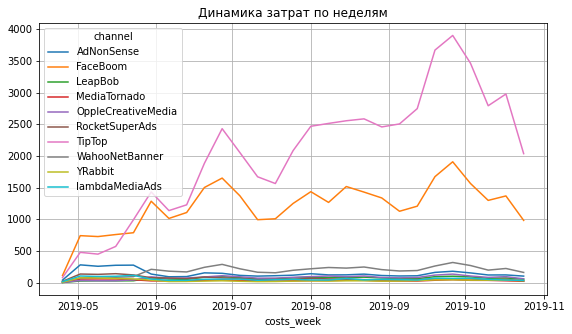

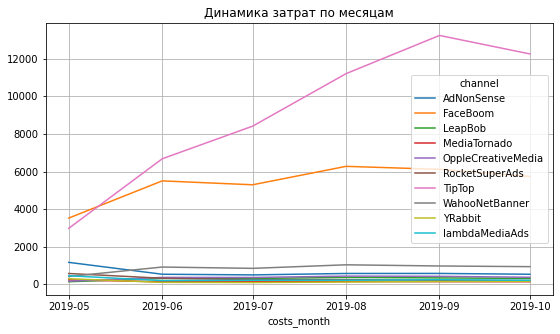

In [25]:
# посмотрим на распределение затрат на каналы по неделям
plt.figure(figsize=(20, 5))
report_week = costs.pivot_table(index='costs_week', columns='channel', values='costs', aggfunc='sum')
report_week.plot(grid=True,
           ax=plt.subplot(1, 2, 2))
plt.title('Динамика затрат по неделям')

plt.show()

# посмотрим на распределение затрат на каналы по месяцам
plt.figure(figsize=(20, 5))
report_month = costs.pivot_table(index='costs_month', columns='channel', values='costs', aggfunc='sum')
report_month.plot(grid=True,
           ax=plt.subplot(1, 2, 2))
plt.title('Динамика затрат по месяцам')

plt.show()

In May, there was the smallest budget, after which it was actively increased almost every month. It's possible that the budget was being increased for the wrong channels. Let's find out.

Let's find out the average cost of acquiring one user (CAC) from each source.

In [26]:
# считаем средний CAC по каналам привлечения

cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values('cac', ascending = False)
)

cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [32]:
# считаем средний CAC по всем каналам привлечения
temporary = profiles.query('channel !="organic"')
average_cac = temporary['acquisition_cost'].mean()
print(f'Средний CAC на одного пользователя для всего проекта: {round(average_cac, 2)}')

Средний CAC на одного пользователя для всего проекта: 1.13


Now we can confirm that the cost of acquiring one user in TipTop is more than double the average CAC for the entire project (TipTop - 2.79).

**Conclusion:**

The total marketing expenses amounted to 105,497 dollars for the period from May 1 to October 27, 2019.

Most of the budget was spent on TipTop and FaceBoom (80%), while in the previous section, we found out that these channels brought in the most paying users. However, TipTop spent almost twice as much, while bringing in only half as many users as FaceBoom. The smallest budget was allocated in May, after which it was actively increased almost every month. We also found out that the cost of acquiring one user in TipTop is more than double compared to FaceBoom.

The average CAC is $1.13. TipTop exceeds it by more than two times - 2.79.

### Advertising profitability assessment

Tasks:

- Analyze advertising profitability using LTV and ROI graphs, as well as graphs of LTV, CAC, and ROI dynamics.
- Check user conversion and its dynamics. Do the same with user retention. Build and study conversion and retention graphs.
- Analyze advertising profitability by device breakdown. Build LTV and ROI graphs, as well as LTV, CAC, and ROI dynamics graphs.
- Analyze advertising profitability by country breakdown. Build LTV and ROI graphs, as well as LTV, CAC, and ROI dynamics graphs.
- Analyze advertising profitability by advertising channel breakdown. Build LTV and ROI graphs, as well as LTV, CAC, and ROI dynamics graphs.

Answer such questions:
- Does advertising aimed at attracting users in general pay off?
- What devices, countries, and advertising channels may have a negative impact on advertising profitability?
- What could be the causes of profitability issues?

Let's establish the timeframe and scope of data analysis for the project. We assume the calendar date to be November 1st, 2019, and the business plan indicates that users should become profitable no later than two weeks after acquisition.

In [ ]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [ ]:
#уберем органических пользоваталей, так как они бесплатны
profiles = profiles.query('channel !="organic"')

We will analyze the profitability of advertising using LTV and ROI charts, as well as charts of LTV, CAC, and ROI dynamics.

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Based on the charts, we can draw the following conclusions:

- The advertising is not profitable. The ROI is always less than 1, although it was profitable in May.
- CAC is unstable and constantly increasing.
- LTV is relatively stable. Therefore, the problem is not with the quality of users.
- The main issue lies with CAC, and we need to work on reducing the cost of acquiring users.

We will also examine user conversion rates and their dynamics, as well as user retention rates.

In [ ]:
# смотрим конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Conversion rates are increasing every day, which may be due to retention efforts.

In [ ]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Retention rates are already declining on the second day.

We will analyze the profitability of advertising broken down by device type. We will create LTV and ROI charts, as well as charts of LTV, CAC, and ROI dynamics.

In [ ]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

In [ ]:
#посмотрим на конверсию с разбивкой по устройствам 
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [ ]:
#посмотрим на удержание с разбивкой по устройствам 

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Based on the charts, we can draw several conclusions:

- The cost of acquiring users for Mac and iPhone devices is the highest.
- Device type has almost no effect on LTV.
- Profitability is poor, with only PC becoming profitable on the 11th day, but even that stopped being profitable from September.
- ROI for all devices began to decline from June.
- The cost of acquiring users increases every month, especially for Mac and iPhone.
- Conversion rates are highest for Mac and iPhone, but their dynamics are not significant.
- Retention rates are better for PC, but retention for all sources declines rapidly after the second day.

We will analyze the profitability of advertising broken down by region.

In [ ]:
# считаем LTV и ROI с разбивкой по регионам 

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

In [ ]:
#посмотрим на конверсию с разбивкой по странам 
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [ ]:
#посмотрим на удержание с разбивкой по странам 

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Based on the charts, we can draw the following conclusions:
- LTV is higher in the United States.
- All countries except the United States become profitable by the fifth day.
- The dynamics indicate that profitability has decreased in the United States since June.
- The most representative CAC chart shows that the cost of acquiring users is decreasing for all countries except the United States since June.
- Conversion rates for users in the United States are higher than for other countries and are constantly increasing.
- Retention rates for users from the United States are declining rapidly every day.

Let's analyze the profitability of advertising with a breakdown by advertising channels.

In [ ]:
#смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

In [ ]:
#посмотрим на конверсию с разбивкой по рекламным каналам 
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [ ]:
#посмотрим на удержание с разбивкой по рекламным каналам  

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Conclusions from the graphs:
- Three channels do not pay off even after 14 days: Tip-Top, Faceboom, AdNoneSense. At the same time, the main budget goes specifically to two of them: Tip-Top and Faceboom.
- The conversion rate is highest for Faceboom and AdNoneSense, but the retention rate for these channels is the lowest.
- Retention for all channels drops on the second day and tends to zero on the 14th.

We will also answer a few questions and summarize:
- Does advertising aimed at attracting users in general pay off? No. The ROI is always below 1.
- Which devices, countries, and advertising channels may have a negative impact on advertising profitability? In the first place, the US and advertising channels TipTop and FaceBoom have a negative impact. It is impossible to single out an outsider among the devices.
- What could be causing profitability problems? About 50% of the budget goes to the least profitable channels and countries.

## Conclusion

Based on the entire study, several main reasons why advertising does not pay off can be identified:
- Low retention rate for the application as a whole, with most users leaving on the second day.
- The most financially viable region, the United States, is not profitable compared to other countries. The cost of attracting users from the United States is constantly increasing, while retention of users from the United States is rapidly declining every day.
- Three channels do not pay off even after 14 days: Tip-Top, Faceboom, AdNoneSense. At the same time, the main budget goes to two of them, Tip-Top and Faceboom. Sharp increase in CAC at Tip-Top. Decrease in retention for all channels on the second day. Faceboom and AdNoneSense have the lowest retention, which stands out against other channels.

Here are some recommendations for the marketing department:
- Review the advertising in the United States, study in detail which users affect the high CAC, perhaps this is the wrong gender, age, certain regions of the United States. Also find out why users from the United States are not returning to the application. Set up retargeting for old users, consider promotions, push notifications, or newsletters.
- Expand geo: set up advertising for other countries in Europe (Scandinavian countries, Italy, Poland), increase the budget for current European countries (Germany, UK, and France), and consider alternative countries where users may have high activity, such as the Philippines, i.e., countries where English is widely spoken and the application is relevant.
- Review advertising channels, increase the budget for the most profitable channels: YRabbit, MediaTornado, lambdaMediaAds, and reduce the budget for TipTop and FaceBoom. Review UTP and banners for these channels and conduct new tests.
- Study what changes occurred in June, apart from the budget increases, that could have affected the deteriorating indicators, to avoid making mistakes again.